## Beating effect for two sinusoids with similar frequencies:
### a toy Blazhko light curve simulation  

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [2]:
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_sample
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroML.time_series import MultiTermFit

When we have a sum of two sin functions:
$$
     y(t) = sin(2\pi f_1) + sin(2\pi f_2),
$$
we can rewrite it using trigonometric equality
$$
       sin(a) + sin(b) = 2 \, cos({a-b\over 2}) \, sin({a+b\over 2})
$$
as
$$
         y(t) = 2 \, cos(2\pi{f_1-f_2\over 2}) \, sin(2\pi {f_1+f_2\over 2}).
$$ 
When $f_1$ and $f_2$ are similar ($f_1 \approx f_2$), we can define 
$$
         f_o = {f_1+f_2\over 2},
$$         
and 
$$
         \Delta f = |{f_1-f_2\over 2}|,
$$
with $\Delta f << f_o$.

The fact that $\Delta f$ is much smaller than $f_o$ means that the period of the cos term is much larger
than the period of the basic oscillation ($f_o$). In other words, the cos term acts as a slow
amplitude modulation of the basic oscillation. 

When the amplitudes of two sin functions are not equal, the math is a bit more complicated but
the basic conclusion about amplitude modulation remains.

When the power spectrum of $y(t)$ is constructed, it will show 3 peaks: the main peak at $f_o$ and
two more peaks at frequencies $f_o \pm \Delta f$. 

For illustration of these results using simulated light curves, please see below.

In [16]:
def beatLightCurve(Ablazhko=0.3, Amain=0.0, plotObs=False):
    
    # Ablazhko: controls modulation strength 
     
    # motivated by LINEAR data for LINEAR ID= 1092244, we adopt for toy model
    fMainPeak = 1.54 # cycles/day, so the principal period is 1/1.54 = 0.65 days
    fBlazhkoPeak = 1.57  # frequency of (the positive) Blazhko peak
                     # Blazhko period = 1/|fBlazhkoPeak-flin| = 33.3 days
    
    # generate a simulated light curve with the same main and Blazhko frequencies
    Ngrid = 10000  # fine sampling of 0.01 day - later we'll subsample 
    Tmax = 100     # we generate light curve for times going from 0 to 100 days
    time = np.linspace(0, Tmax, Ngrid)
    # assume that f1 > f2 
    # we know that delta f = |f1 - f2|/2 = (f1 - f2)/2 
    # and f0 = (f1 + f2)/2
    # in Blazhko context, we call it 
    # f0 = fMainPeak and fBlazhkoPeak = fMainPeak + delta f
    
    # main oscillation, amplitude controled by Amain:
    LCmain = Amain*np.sin(2*3.14158*time*fMainPeak) 
    # add Blazhko contribution, with arbitrary normalization (Ablazhko)
    LCb = LCmain + Ablazhko*np.sin(2*3.14158*time*(2*fMainPeak-fBlazhkoPeak)) 
    LCb = LCb + Ablazhko*np.sin(2*3.14158*time*fBlazhkoPeak)
    # normalize to 1     
    LCb = LCb/np.max(LCb) 
    
    # also compute with trigonometric identity
    f1 = fBlazhkoPeak
    f2 = 2*fMainPeak-fBlazhkoPeak
    LCtrig = 2 * Ablazhko*np.cos(3.14158*time*(f1-f2)/2)*np.sin(3.14158*time*(f1+f2)/2)
    # normalize to 1     
    LCtrig = LCtrig/np.max(LCtrig) 

    # red is just two Blazhko modes, blue is with main oscillation added (amplitude=Amain)
    plotSimLC(time, LCb, LCtrig, "dummy", "dummy", plotObs)
    
    return 

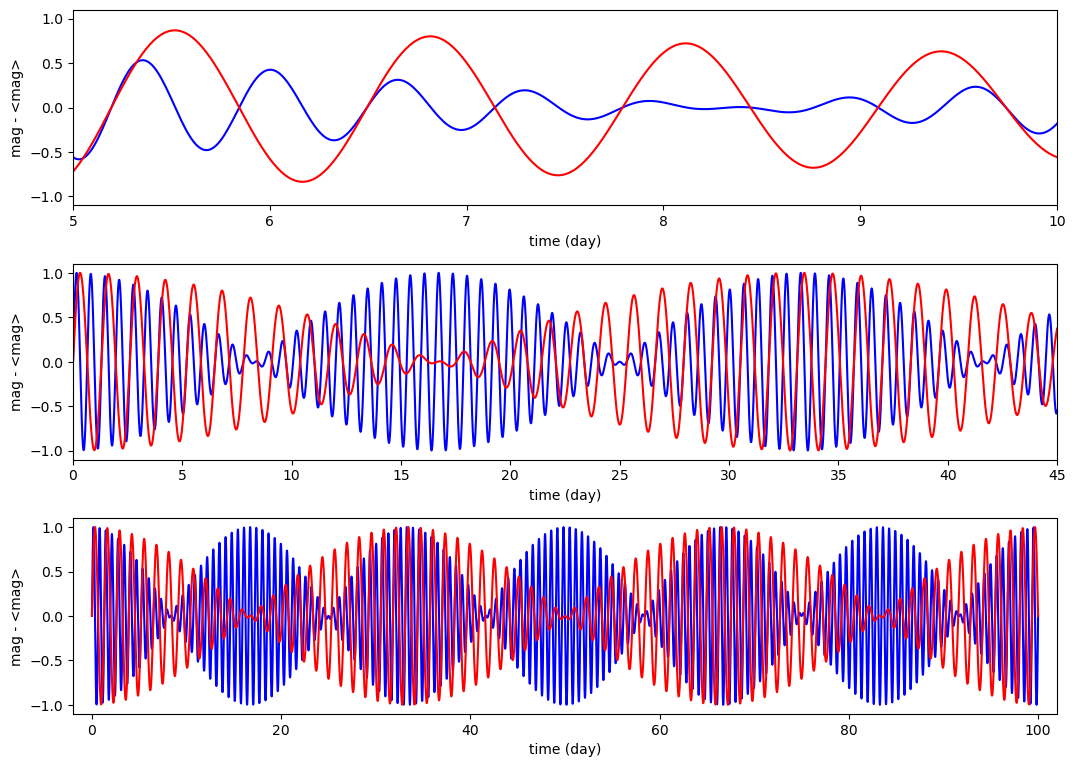

In [17]:
# without main oscillation
beatLightCurve(Ablazhko=0.3, Amain=0.0)

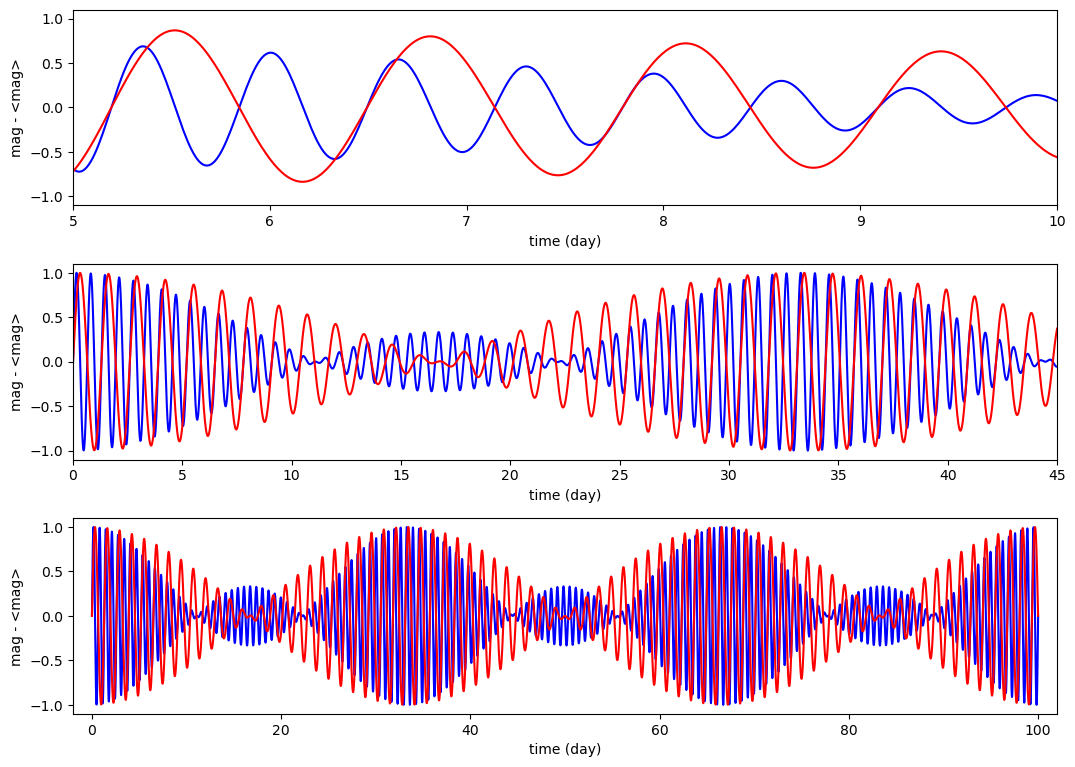

In [18]:
beatLightCurve(Ablazhko=0.3, Amain=0.3)

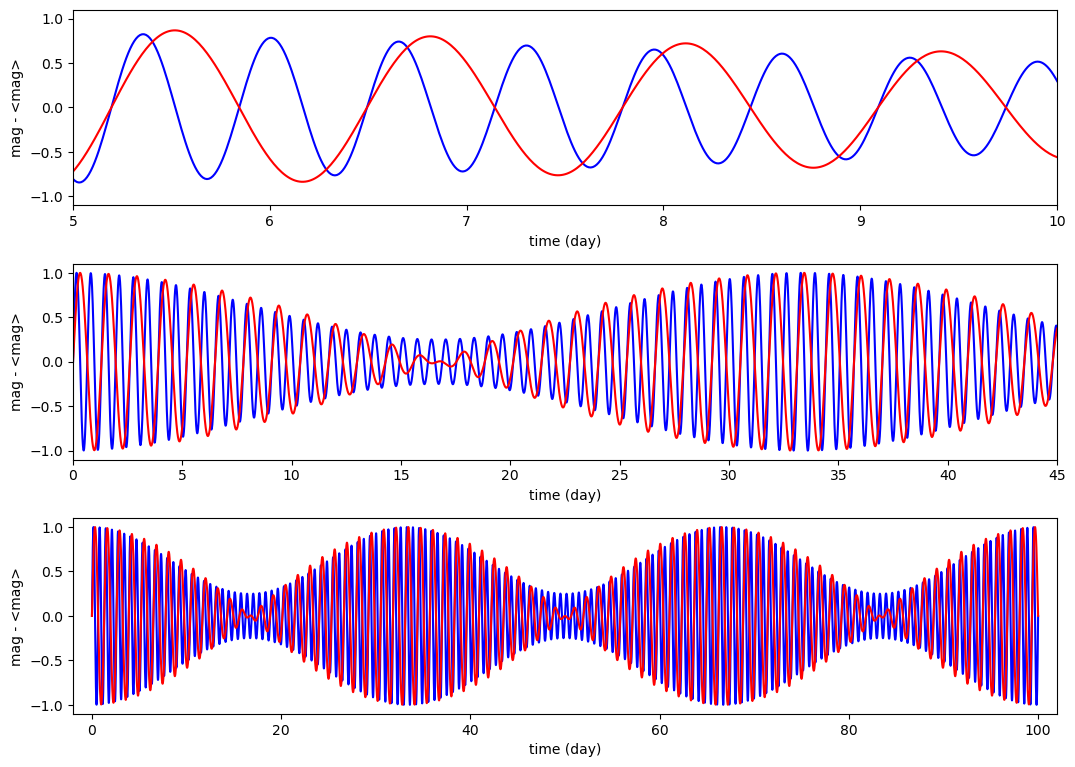

In [19]:
beatLightCurve(Ablazhko=0.3, Amain=1.0)

### this code might already exist in some src/*.py file...

In [20]:
def plotBlazhkoPeaks(fL, pL, fac=1.008, plotSave=False, verbose=True):
    
    flin = fL[np.argmax(pL)]

    fFolded, pFolded, fMainPeak, fBlazhkoPeak, BlazhkoPeriod, BpowerRatio, Bsignificance = \
    getBlazhkoPeak(fL, pL, verbose=verbose)

    ## at some point, we will read periodograms back from files...
    fig = plt.figure(figsize=(10, 12))
    fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)    
    
    # plot zoomed-in power spectrum
    ax = fig.add_subplot(311)

    ax.plot(fL, pL, c='b')
    ax.plot([flin, flin], [0,1], lw = 1, c='r', ls='--')
    ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0, 0.7*np.max(pFolded)], lw = 1, c='r', ls='--')
    ax.plot([2*flin-fBlazhkoPeak, 2*flin-fBlazhkoPeak], [0, 0.7*np.max(pFolded)], lw = 1, c='r', ls='--')
    # show 1 year alias
    f1yr = flin+1/365.0
    ax.plot([f1yr, f1yr], [0,0.7*np.max(pFolded)], lw = 1, ls='-.', c='green')
    f1yr = flin-1/365.0
    ax.plot([f1yr, f1yr], [0,0.7*np.max(pFolded)], lw = 1, ls='-.', c='green')

    ax.text(0.03, 0.96, "", ha='left', va='top', transform=ax.transAxes)
    if (fBlazhkoPeak > flin*fac):
        ax.set_xlim(0.99*(2*flin-fBlazhkoPeak), 1.01*fBlazhkoPeak)
    else:
        ax.set_xlim(flin/fac, flin*fac)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
    if ymax>1.0: ymax=1.0
    ax.set_ylim(0, ymax)
    ax.set_ylabel('Lomb-Scargle power')
    ax.set_xlabel('frequency (d$^{-1}$)')

    # plot folder power spectrum
    ax = fig.add_subplot(312)

    ax.plot(fFolded, pFolded, c='b')
    ax.plot([fBlazhkoPeak, fBlazhkoPeak], [0,0.4*np.max(pFolded)], lw = 1, ls='--', c='r')
    # show 1 year alias
    f1yr = flin+1/365.0
    ax.plot([f1yr, f1yr], [0,0.4*np.max(pFolded)], lw = 1, ls='-.', c='green')
    
    powerFar = pFolded[fFolded>fBlazhkoPeak]  # frequencies beyond the second peak
    powerFarMedian = np.median(powerFar)      # the median power
    powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
    noise5sig = powerFarMedian+5*powerFarRMS
    
    if (fBlazhkoPeak > flin*fac):
        ax.plot([flin+0.5*(fBlazhkoPeak-flin), 1.01*fBlazhkoPeak], [noise5sig, noise5sig], lw = 1, ls='--', c='cyan')
        ax.set_xlim(flin, 1.01*fBlazhkoPeak)
    else:
        ax.plot([flin+0.5*(fBlazhkoPeak-flin), flin*fac], [noise5sig, noise5sig], lw = 1, ls='--', c='cyan')
        ax.set_xlim(flin, flin*fac)

    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ylim = ax.get_ylim()
    ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
    if ymax>1.0: ymax=1.0
    ax.set_ylim(0, ymax)
    ax.set_ylabel('folded power')
    ax.set_xlabel('frequency (d$^{-1}$)')

    if plotSave:
        plotName = '../plots/Blazhko.png'
        plt.savefig(plotName, dpi=600)
        print('saved plot as:', plotName) 
    plt.show()     
    return fBlazhkoPeak   

In [21]:
# plot light curve vs. time with 3 different zoom levels
def plotSimLC(time, LCmain, LCb, tObs, LCbObs, plotObs=True):
    
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(hspace=0.3, bottom=0.06, top=0.94, left=0.12, right=0.94)

    ax = fig.add_subplot(311)
    ax.plot(time, LCmain, c='b')
    ax.plot(time, LCb, c='r')
    if plotObs: ax.scatter(tObs, LCbObs, c='black') # "data"
    ax.set_xlim(5,10)
    ax.set_ylabel('mag - <mag>')
    ax.set_xlabel('time (day)')

    ax = fig.add_subplot(312)
    ax.plot(time, LCmain, c='b')
    ax.plot(time, LCb, c='r')
    if plotObs: ax.scatter(tObs, LCbObs, c='black') # "data"
    ax.set_xlim(0,45)
    ax.set_ylabel('mag - <mag>')
    ax.set_xlabel('time (day)')

    ax = fig.add_subplot(313)
    ax.plot(time, LCmain, c='b')
    ax.plot(time, LCb, c='r')
    if plotObs: ax.scatter(tObs, LCbObs, c='black') # "data"

    ax.set_xlim(-2, 102)
    ax.set_ylabel('mag - <mag>')
    ax.set_xlabel('time (day)')
 
    plt.show()
    
    
# plot full LS periodogram
def plotLSperiodogram(freq, LSPS):
    
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.3, bottom=0.06, top=0.94, left=0.12, right=0.94)

    ax = fig.add_subplot(311)
    ax.plot(freq, LSPS, c='b')
    ax.set_xlim(1.0,2.0)
    ax.set_ylabel('LS power')
    ax.set_xlabel('frequency (1/day)')

    ax = fig.add_subplot(312)
    ax.plot(1/freq, LSPS, c='b')
    ax.set_xlim(0.5,1.0)
    ax.set_ylabel('LS power')
    ax.set_xlabel('period (day)')
 
    plt.show()

##  periodogram tools

In [22]:
# similar to doPeriodsOrig(), but first try with auto frequency grid
# and then "zoom-in" around the highest LS power peak 
# note: freqFac=1.02 allows search for Blazhko periods longer than 50*basic period, so ~25 days and longer
# note: freqFac=1.05 allows search for Blazhko periods longer than 20*basic period, so ~10 days and longer
def doPeriods(time, mag, magErr, nterms, lsPS=False, nyquist=100, freqFac=1.05):
    try:
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        best_freq = frequencyAuto[np.argmax(powerAuto)]
        # frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        frequency = np.arange(1.0, 2.0, 5e-5)
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        # hack: limit around known frequency to avoid aliases
        powerRestricted = power[(frequency>1.3)&(frequency>1.7)]
        freqRestricted = frequency[(frequency>1.3)&(frequency>1.7)]
        periodRestricted = 1. / freqRestricted
        best_period = period[np.argmax(powerRestricted)] # choosing the period with the highest power
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        print('failed for ID=', Lid)
        return 'Error in doPeriods'
    
# given frequency and Lomb-Scargle power, return parameters for a candidate Blazhko peak
def getBlazhkoPeak(freq, LSpow, verbose=False):
    # no. of points
    Npts = np.size(LSpow)
    # index for the main peak
    imax = np.argmax(LSpow)
    # 1 year alias frequency (factor 1.02 to push it a bit over the maximum)
    f1yr = freq[imax] + 1.02/365
    # iDelta is the max. width for folding around the main peak
    if (imax < Npts/2):
        iDelta = imax
    else:
        iDelta = Npts - imax
    # folded versions 
    fFolded = freq[imax:imax+1+iDelta]  
    pLeft = LSpow[imax-iDelta:imax+1]  
    pRight = LSpow[imax:imax+1+iDelta]
    pFolded = 0*fFolded
    for i in range(0, iDelta-1):
        # multiply the two branches to increase SNR 
        pFolded[i] = pLeft[-i-1] * pRight[i] 
    # now search for the strongest secondary minimum (after the main one at index=0)
    foundMin = 0
    foldedMax = 0 
    ifoldedMax = 0
    # NB: the first point is the highest by construction (the main peak)
    for i in range(1, iDelta):
        if ((foundMin==0)&(pFolded[i] > pFolded[i-1])):
            # the first time we passed through a local minimum
            if (fFolded[i]>f1yr): foundMin = 1
        if foundMin:
            # after the first local minimum, remember the maximum power and its location
            if (pFolded[i] > foldedMax):
                foldedMax = pFolded[i]
                ifoldedMax = i
    # done, return useful quantities       
    fMainPeak = freq[imax] # location of the main peak
    fBlazhkoPeak = fFolded[ifoldedMax] # location of the second strongest peak
    BlazhkoPeriod = 1/(fBlazhkoPeak - fMainPeak) # expression for Blazhko period
    BpowerRatio = pFolded[ifoldedMax]/fFolded[0] # the ratio of power for the 2nd and 1st peaks
    # now compare the second peak's strength to the power at larger frequencies (presumably noise)
    powerFar = pFolded[fFolded>fBlazhkoPeak]  # frequencies beyond the second peak
    powerFarMedian = np.median(powerFar)      # the median power
    powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
    Bsignificance = (pFolded[ifoldedMax]-powerFarMedian)/powerFarRMS  # how many sigma above median?
    if (verbose):
        print('main frequency (1/day):', fMainPeak)
        print('detected second peak at index:', ifoldedMax)
        print('Blazhko peak frequency (1/day):', fBlazhkoPeak)
        print('Blazhko peak relative strength:', BpowerRatio)
        print('median power beyond Blazhko peak:', powerFarMedian)
        print('power rms beyond Blazhko peak:', powerFarRMS)
        print('Blazhko peak significance:', Bsignificance)
        print('Blazhko period (day):', BlazhkoPeriod)
    return fFolded, pFolded, fMainPeak, fBlazhkoPeak, BlazhkoPeriod, BpowerRatio, Bsignificance

In [27]:
def simulatedLightCurve(Ablazhko=0.3, Ndata=500, magErr=0.05):
    
    # Ablazhko: controls modulation strength 
    # Ndata: the number of data points (~250 in LINEAR/ZTF analysis)
    
    # motivated by LINEAR data for LINEAR ID= 1092244, we adopt for toy model
    fMainPeak = 1.54 # cycles/day, so the principal period is 1/1.54 = 0.65 days
    fBlazhkoPeak = 1.57  # frequency of (the positive) Blazhko peak
                     # Blazhko period = 1/|fBlazhkoPeak-flin| = 33.3 days
    
    
    # generate a simulated light curve with the same main and Blazhko frequencies
    Ngrid = 10000  # fine sampling of 0.01 day - later we'll subsample 
    Tmax = 100     # we generate light curve for times going from 0 to 100 days
    time = np.linspace(0, Tmax, Ngrid)
    # main oscillation: 
    LCmain = np.sin(2*3.14158*time*fMainPeak) 
    # add Blazhko contribution, with arbitrary normalization (Ablazhko)
    LCb = LCmain + Ablazhko*np.sin(2*3.14158*time*(2*fMainPeak-fBlazhkoPeak)) 
    LCb = LCb + Ablazhko*np.sin(2*3.14158*time*fBlazhkoPeak)
    # normalize to 1     
    LCb = LCb/np.max(LCb) 
    
    # here we simulate observations, instead of Ngrid points, we will have
    tObs = Tmax * np.random.random(Ndata)
    # and now we re-evaluate light curve (we could do linear interpolation, too)
    LCmainObs = np.sin(2*3.14158*tObs*fMainPeak) 
    LCbObs = LCmainObs + Ablazhko*np.sin(2*3.14158*tObs*(2*fMainPeak-fBlazhkoPeak)) 
    LCbObs = LCbObs + Ablazhko*np.sin(2*3.14158*tObs*fBlazhkoPeak) 
    LCbObs = LCbObs/np.max(LCbObs) 

    # add errors
    magErrObs = magErr + 0*tObs
    LCbObsErr = LCbObs + np.random.normal(0, magErrObs)
    
    # plot light curve
    plotSimLC(time, LCmain, LCb, tObs, LCbObsErr)
    
    # get periodogram
    print('computing periodogram and Blazhko analysis - this can take tens of seconds...')
    bestPeriodObs, frequencyObs, powerObs = doPeriods(tObs, LCbObsErr, magErrObs, 3, lsPS=True)
    plotLSperiodogram(frequencyObs, powerObs)
    
    # hack: restrict the range that was used for plotting to help Blazhko algorithm
    fOK = frequencyObs[(frequencyObs>1.30)&(frequencyObs<1.75)]
    pOK = powerObs[(frequencyObs>1.30)&(frequencyObs<1.75)]
    fBlazhkoPeak = plotBlazhkoPeaks(fOK, pOK, fac=1.008, plotSave=False, verbose=True)
    
    return time, LCmain, LCb, LCbObs 

## this example is good for showing and discussing in "radnja"

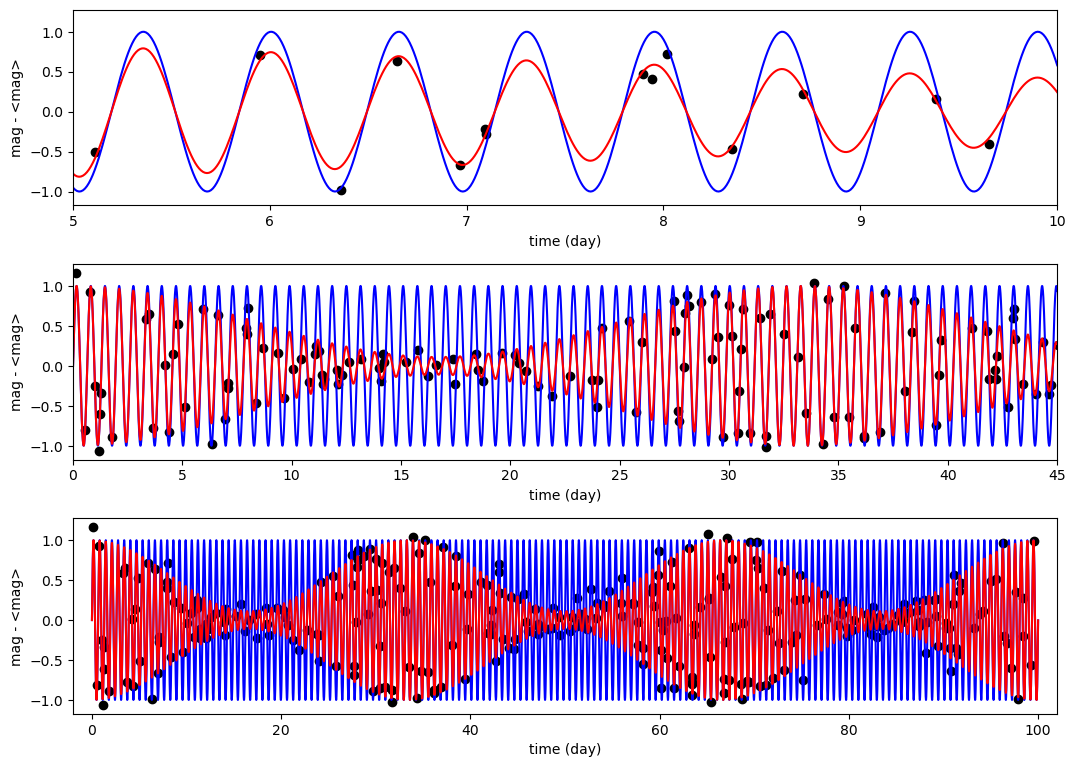

computing periodogram and Blazhko analysis - this can take tens of seconds...


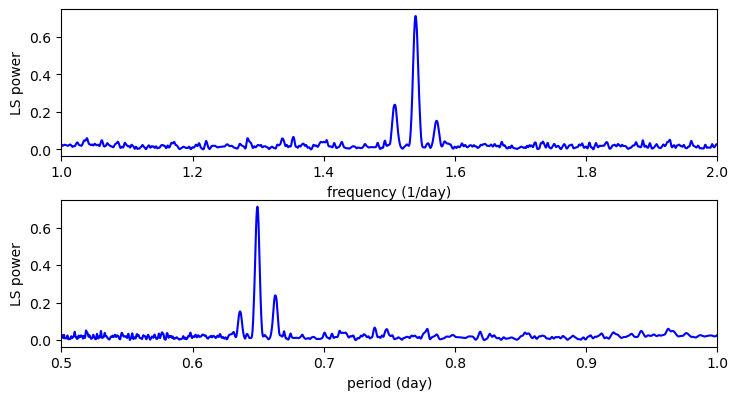

main frequency (1/day): 1.5398500000011393
detected second peak at index: 638
Blazhko peak frequency (1/day): 1.5717500000012066
Blazhko peak relative strength: 0.023606744412994738
median power beyond Blazhko peak: 0.00027045457099324406
power rms beyond Blazhko peak: 0.0041970196235744045
Blazhko peak significance: 8.596669553490347
Blazhko period (day): 31.347962382378988


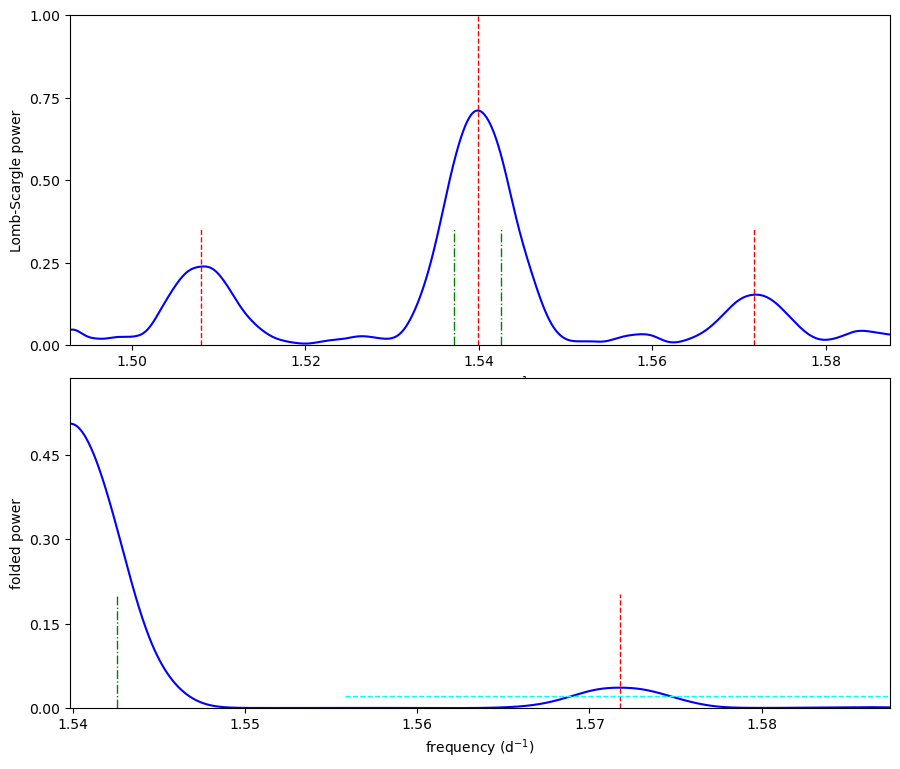

In [28]:
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.4, Ndata=300, magErr=0.1)

## try different combinations of parameters...

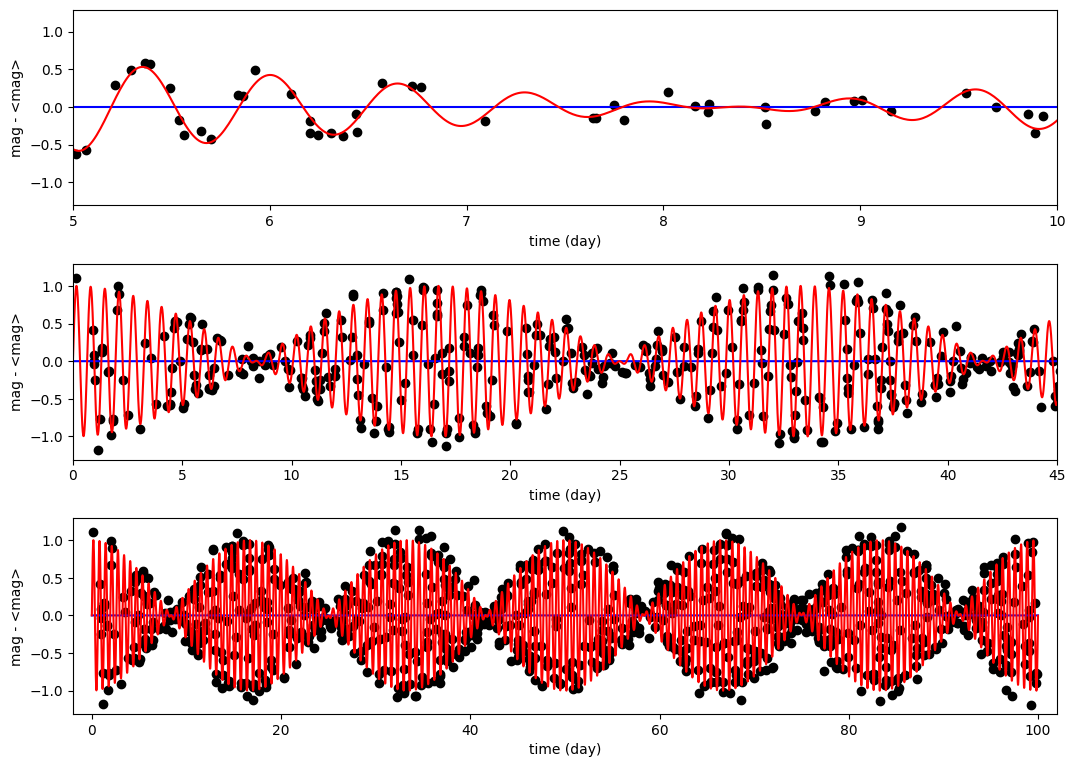

computing periodogram and Blazhko analysis - this can take tens of seconds...


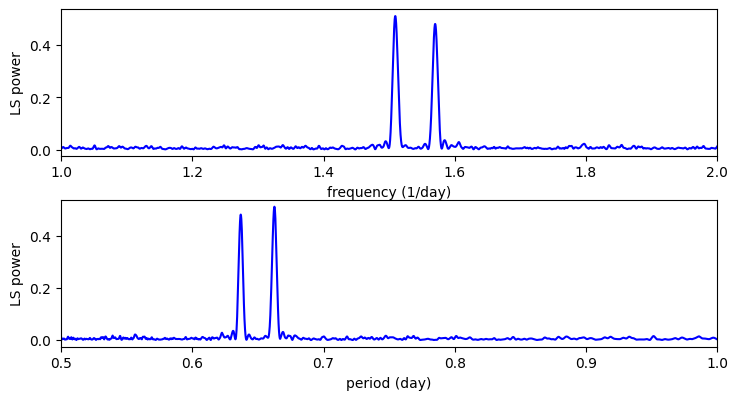

main frequency (1/day): 1.5093000000010748
detected second peak at index: 1159
Blazhko peak frequency (1/day): 1.567250000001197
Blazhko peak relative strength: 0.001686329832004698
median power beyond Blazhko peak: 3.9993964691173855e-05
power rms beyond Blazhko peak: 0.00033296223489667217
Blazhko peak significance: 7.523927305247576
Blazhko period (day): 17.256255392543395


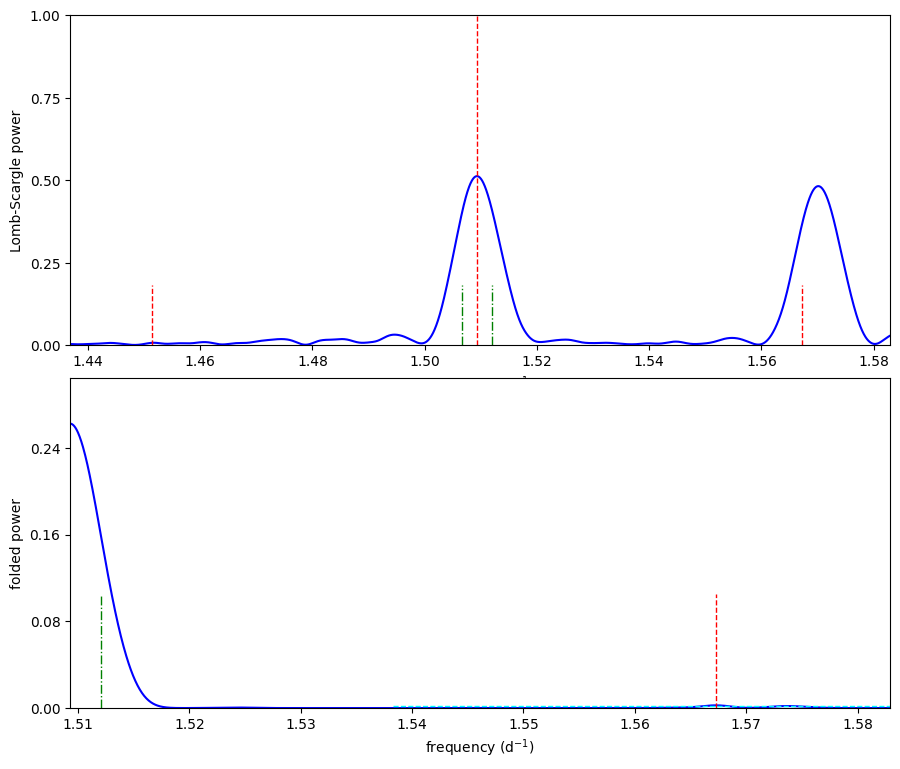

In [31]:
# more data points
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.4, Ndata=1000, magErr=0.1)

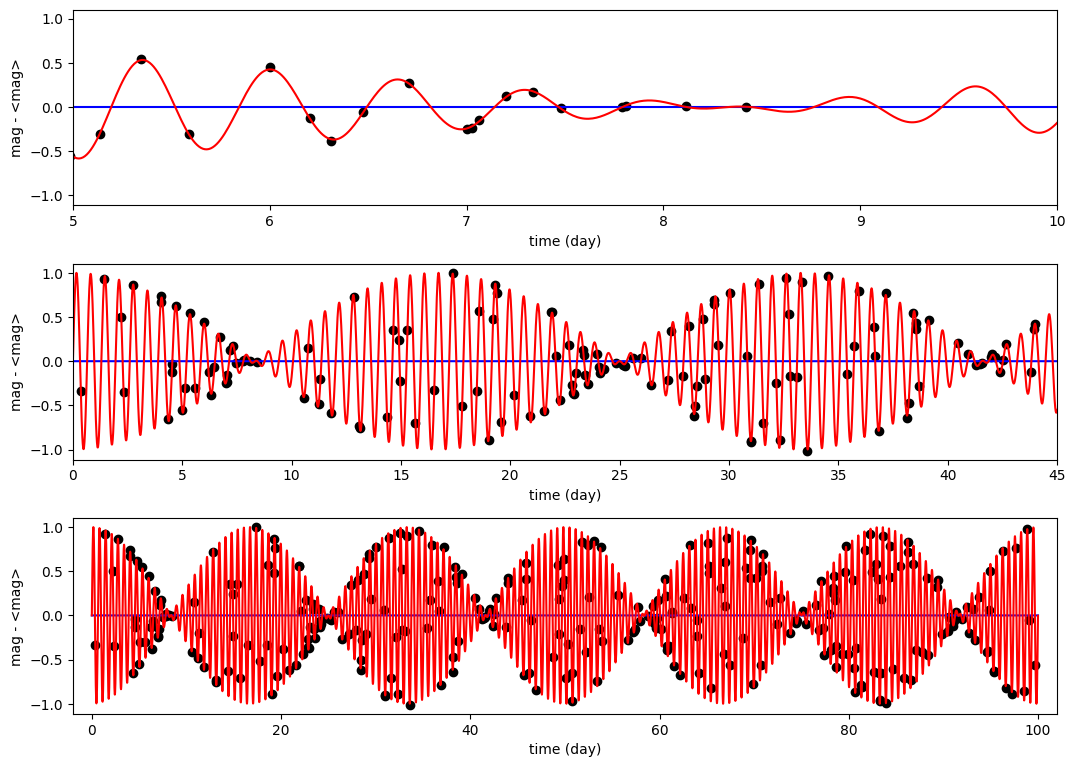

computing periodogram and Blazhko analysis - this can take tens of seconds...


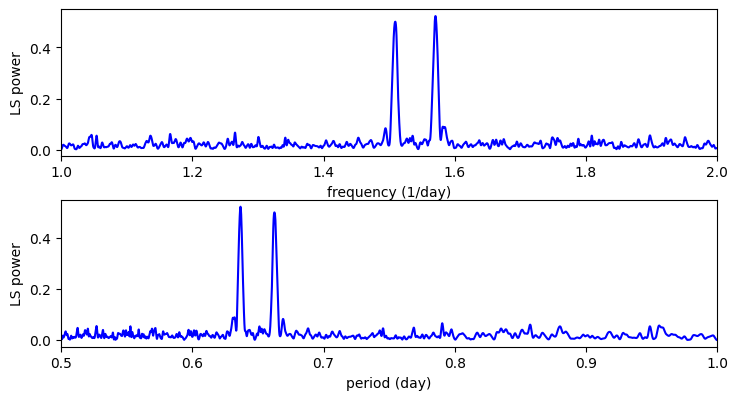

main frequency (1/day): 1.5706000000012041
detected second peak at index: 1260
Blazhko peak frequency (1/day): 1.633600000001337
Blazhko peak relative strength: 0.007111676922526978
median power beyond Blazhko peak: 0.00037973852838293426
power rms beyond Blazhko peak: 0.0017938347670403633
Blazhko peak significance: 6.014969407661011
Blazhko period (day): 15.873015872982377


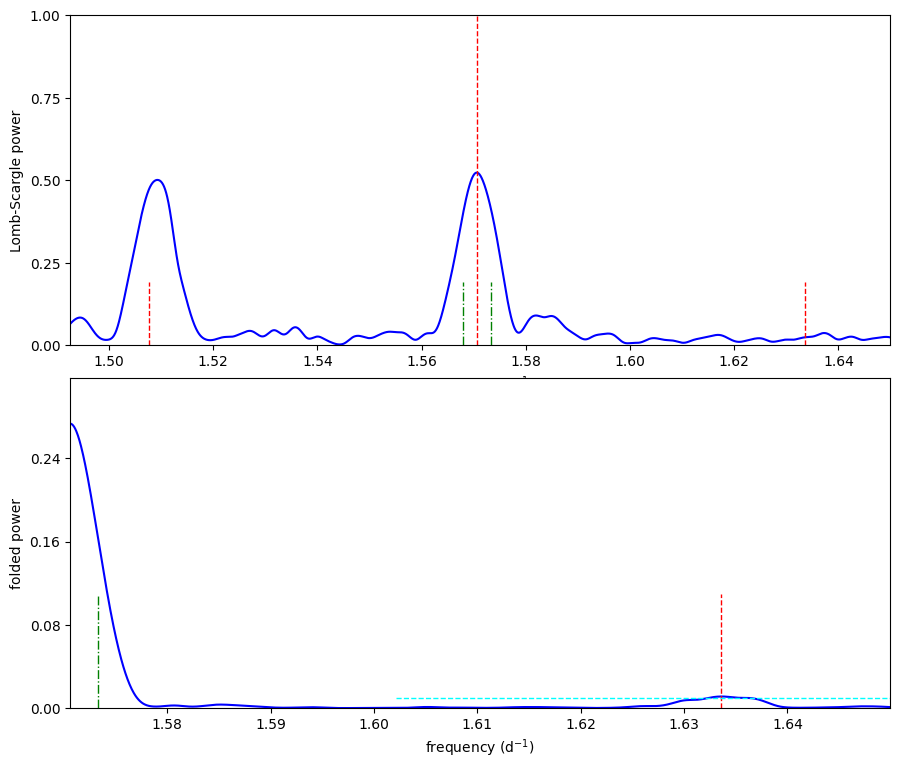

In [32]:
# smaller errors
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.4, Ndata=300, magErr=0.01)

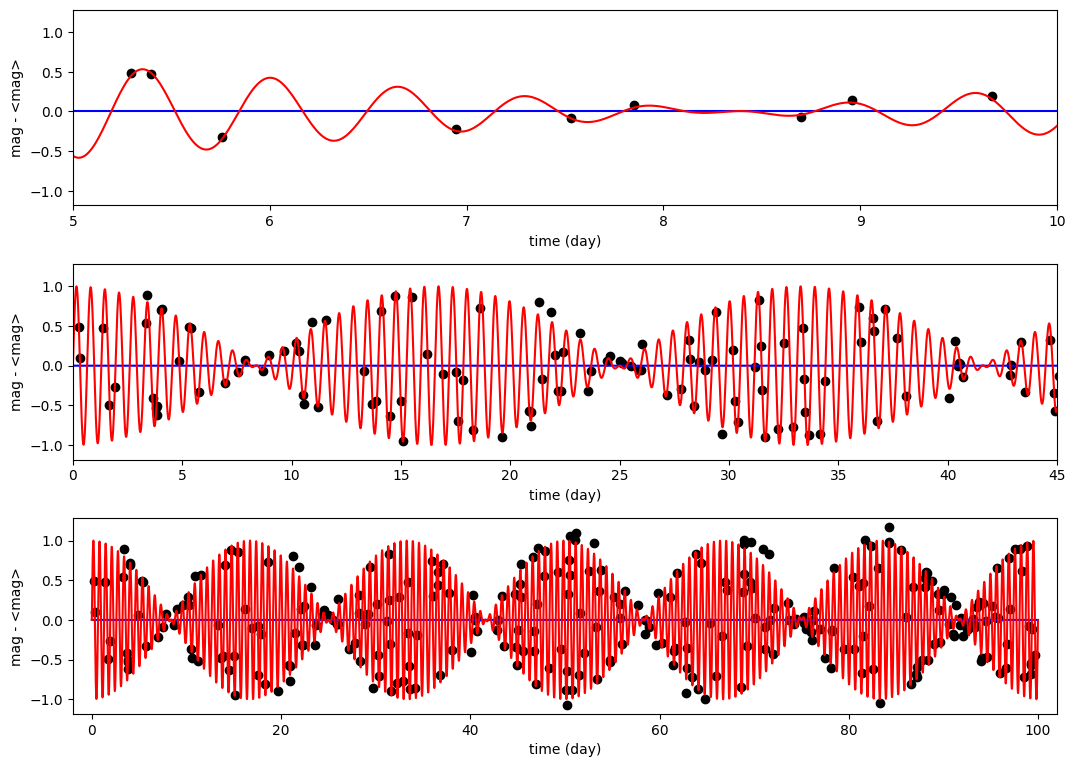

computing periodogram and Blazhko analysis - this can take tens of seconds...


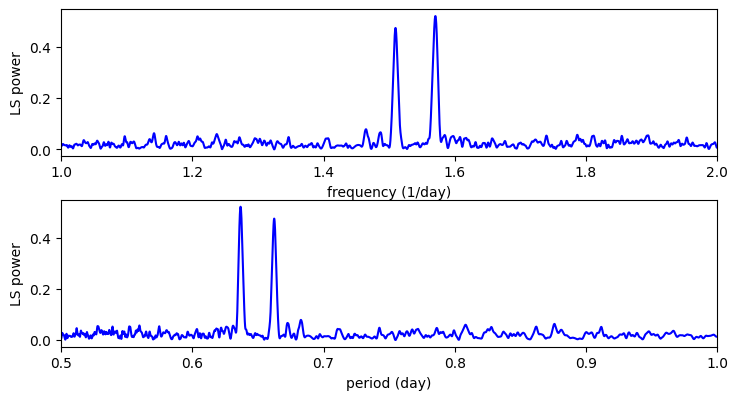

main frequency (1/day): 1.5704500000012038
detected second peak at index: 1224
Blazhko peak frequency (1/day): 1.631650000001333
Blazhko peak relative strength: 0.008549308613364502
median power beyond Blazhko peak: 0.00030966247144905535
power rms beyond Blazhko peak: 0.0013176974309509657
Blazhko peak significance: 9.954181386658266
Blazhko period (day): 16.339869281011268


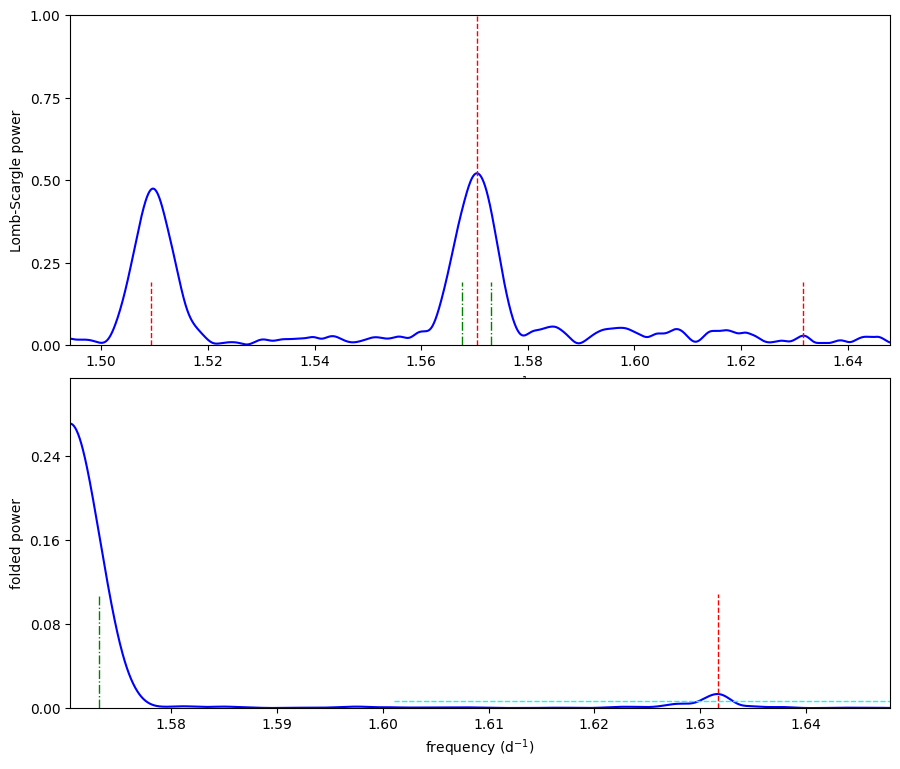

In [33]:
# weaker Blazhko contribution
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.2, Ndata=300, magErr=0.1)

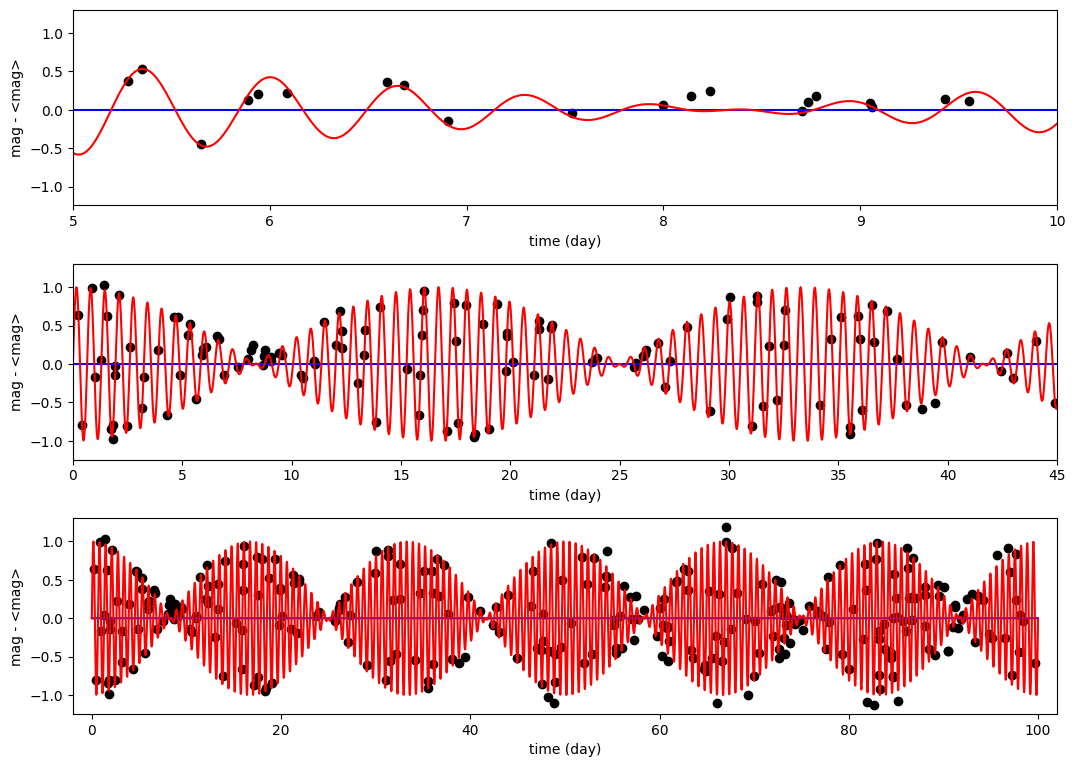

computing periodogram and Blazhko analysis - this can take tens of seconds...


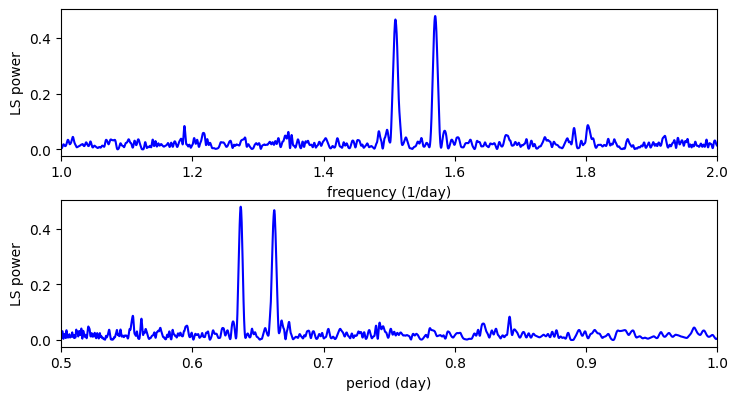

main frequency (1/day): 1.5701500000012032
detected second peak at index: 1269
Blazhko peak frequency (1/day): 1.633600000001337
Blazhko peak relative strength: 0.006357283834173347
median power beyond Blazhko peak: 0.00045205144270504995
power rms beyond Blazhko peak: 0.0011097273146323582
Blazhko peak significance: 8.587549070725562
Blazhko period (day): 15.760441292322927


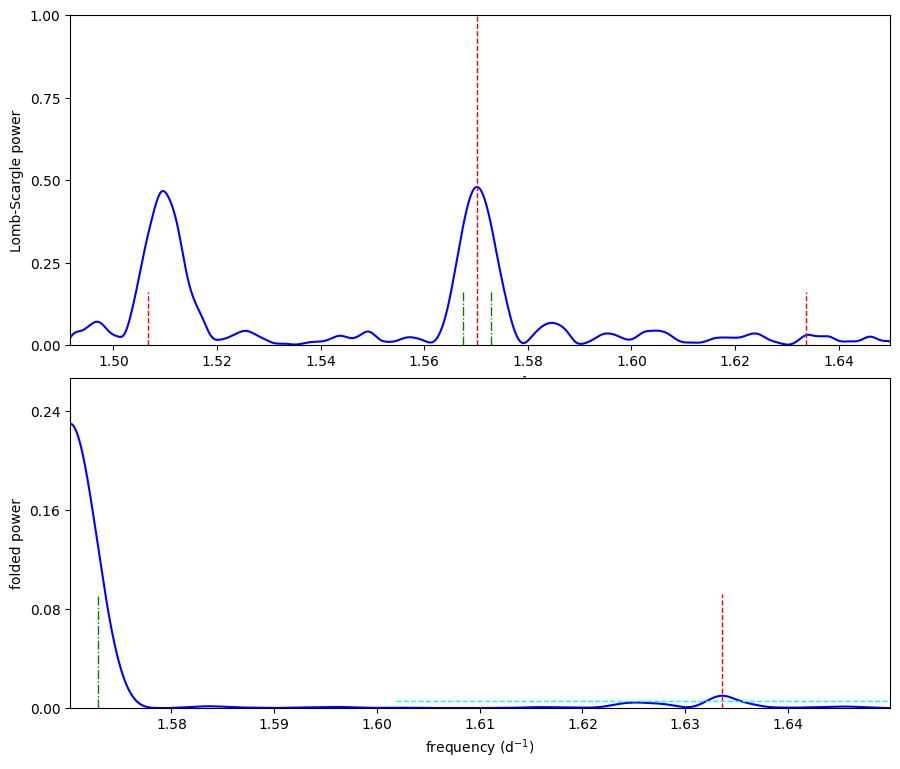

In [34]:
# stronger Blazhko contribution
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.6, Ndata=300, magErr=0.1)

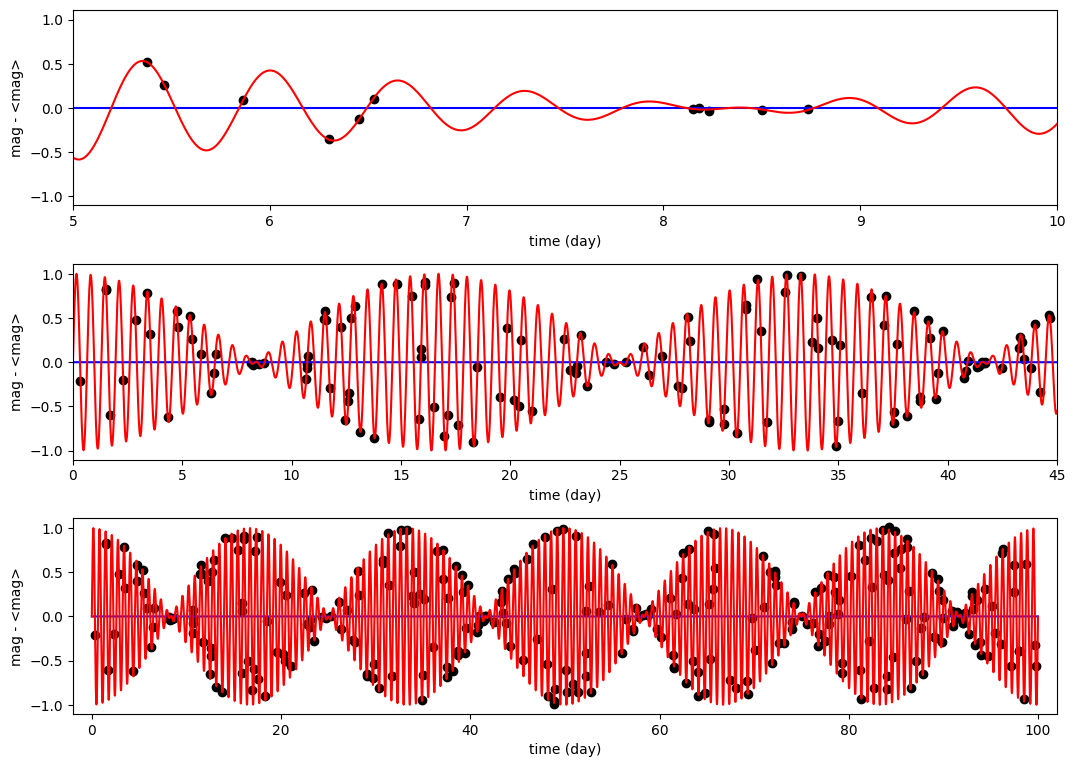

computing periodogram and Blazhko analysis - this can take tens of seconds...


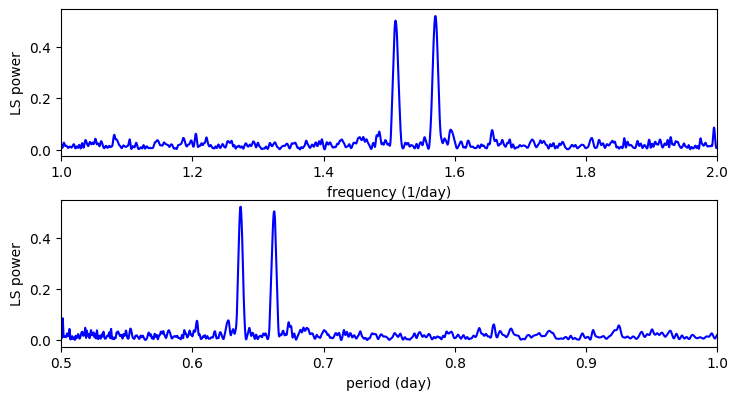

main frequency (1/day): 1.570500000001204
detected second peak at index: 1719
Blazhko peak frequency (1/day): 1.6564500000013853
Blazhko peak relative strength: 0.00327518717361426
median power beyond Blazhko peak: 0.0004377141181087624
power rms beyond Blazhko peak: 0.000725844774933303
Blazhko peak significance: 6.483434889351931
Blazhko period (day): 11.634671320510643


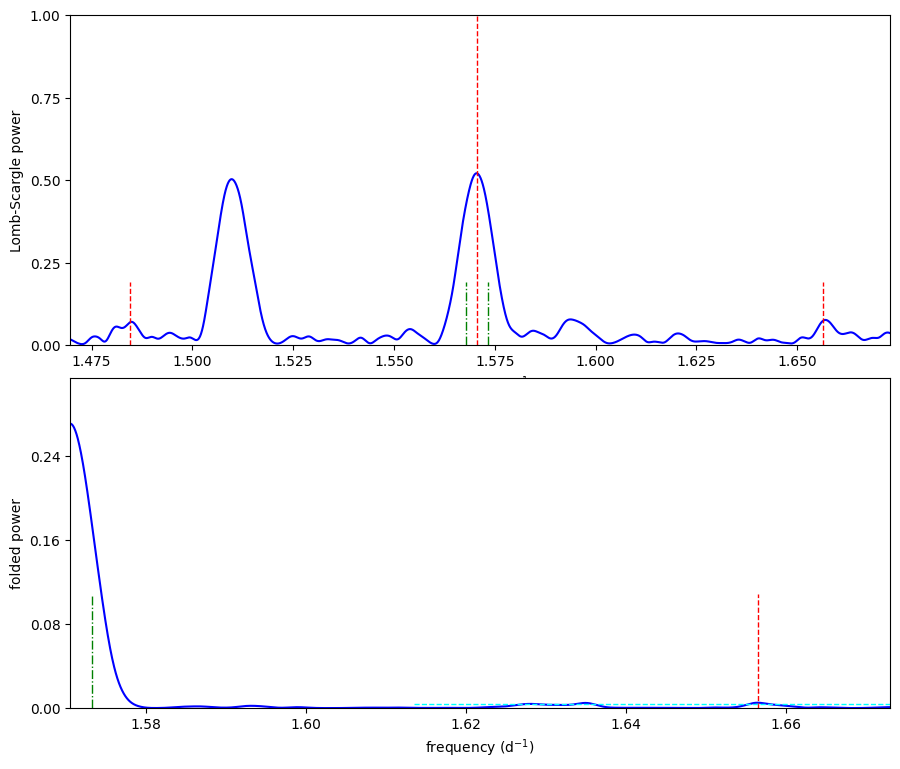

In [35]:
# even stronger Blazhko contribution, more data points, smaller errors...
time, LCmain, LCb, LCbObs = simulatedLightCurve(Ablazhko=0.8, Ndata=300, magErr=0.01)